In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import seaborn as sns
sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc

## check overmassive BH in small gal

In [2]:
cat_dir = "/work2/06431/yueyingn/ASTRID-II/subfind/subfind-483/job8-reduce/ASTRID_subfind_galaxy_catalog_483.npy"
cat = np.load(cat_dir)

In [3]:
cat.dtype

dtype([('Mstar', '<f8'), ('MassCenterPos', '<f8', (3,)), ('SFR', '<f8'), ('MBH', '<f8'), ('MBHdot', '<f8'), ('numBH', '<i4'), ('FOFID', '<i4'), ('sgpID', '<i4')])

10


[Text(0.5, 0, 'log(mstar)'), Text(0, 0.5, 'log(mbh)')]

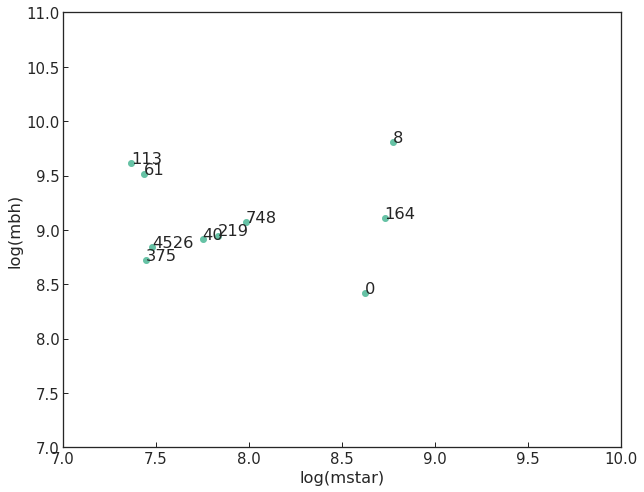

In [4]:
mask = cat['MBH'] > 1e8
mask &= cat['Mstar'] < 1e9
sel = cat[mask]
print(len(sel))

fig, ax = plt.subplots(1,1,figsize=(10,8))
logms = np.log10(sel['Mstar'])
logmb = np.log10(sel['MBH'])
ax.scatter(np.log10(sel['Mstar']), np.log10(sel['MBH']))
for i, txt in enumerate(logms):
    ax.annotate(sel["FOFID"][i], (logms[i], logmb[i]))
ax.set_xlim([7,10])
ax.set_ylim([7,11])
ax.set(xlabel='log(mstar)', ylabel='log(mbh)')

In [6]:
hh = 0.6774
pig = BigFile("/home1/08942/nianyic/ASTRID2_PIG/PIG_483/")
Length = pig['FOFGroups/LengthByType']
Offset = pig['FOFGroups/OffsetByType']
idx = BigFile("/home1/08942/nianyic/asterix/subfind-idx/subfind_483/")

0 1519
[179061127805]
634564


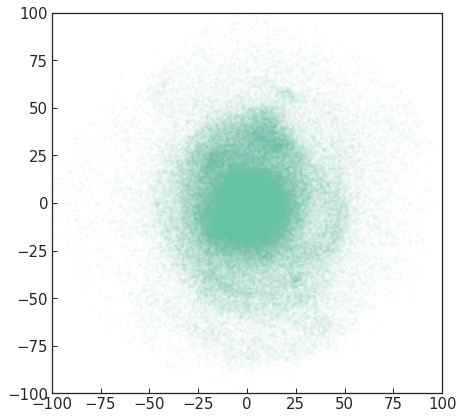

8 221
[258459903385]
3599703


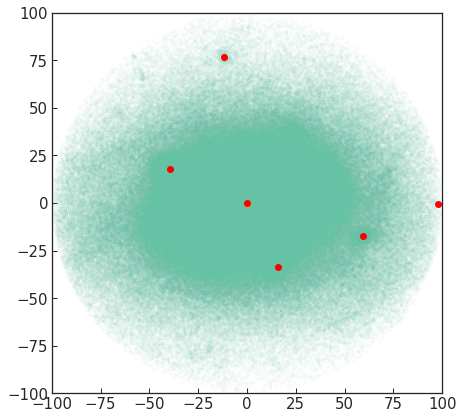

40 442
[228920088280]
897346


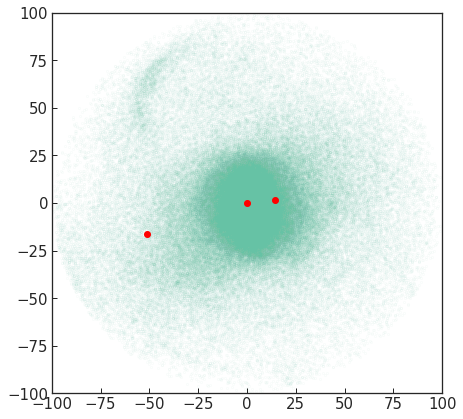

61 726
[176408621672]
2165031


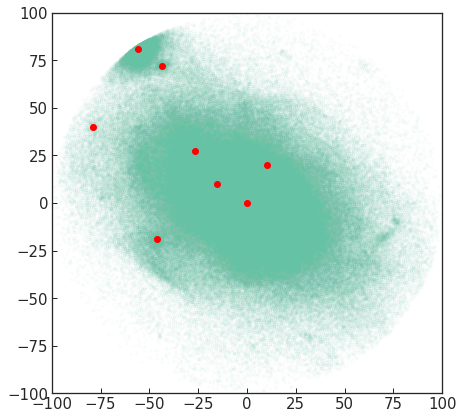

113 615
[274493954053]
2114363


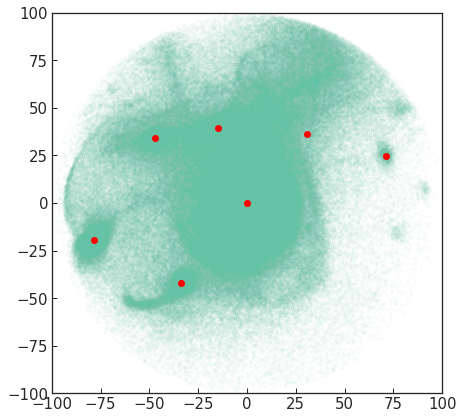

164 82
[223551747820]
1587757


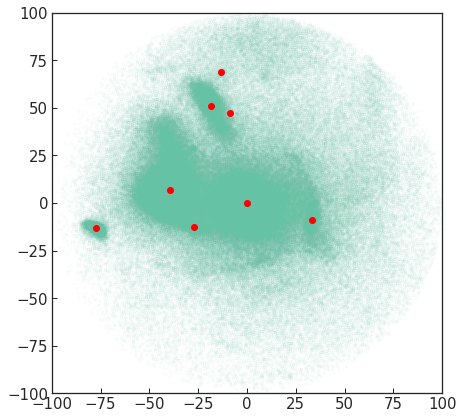

219 263
[191165822345]
1299684


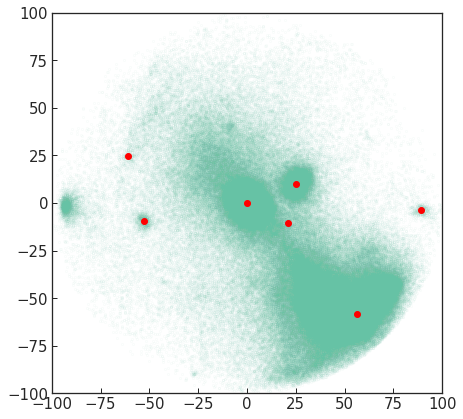

375 350
[244579412290]
1030198


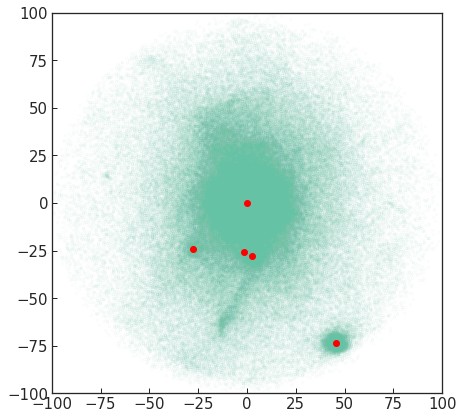

748 128
[311151631522]
757700


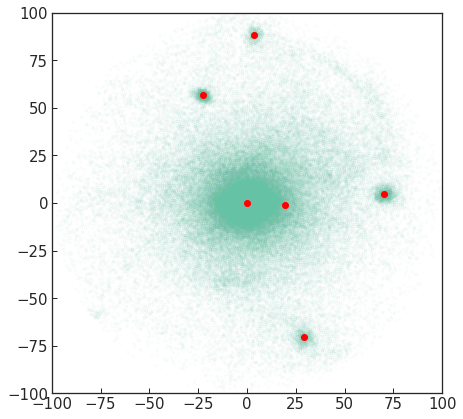

4526 75
[217678941137]
687765


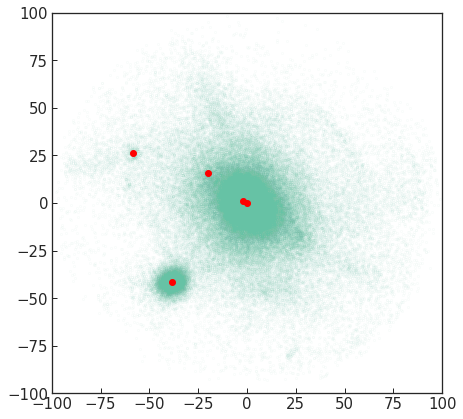

In [15]:
for i, s in enumerate(sel):
    gidx_tar = s["FOFID"]
    sidx_tar = s["sgpID"]
    com = s["MassCenterPos"]
    
    com_all = cat["MassCenterPos"][cat['FOFID'] == gidx_tar]
    print(gidx_tar, sidx_tar)

    grp = gidx_tar
    start, end = Offset[grp], Offset[grp] + Length[grp]
    
    pos4 = pig['4/Position'][start[4] : end[4]]
    pos5 = pig['5/Position'][start[5] : end[5]]
    mass5 = pig['5/BlackholeMass'][start[5] : end[5]] * 1e10/hh
    id5 = pig['5/ID'][start[5] : end[5]]

    sidx5 = idx['5/Subfind-SubGrpIndex2'][start[5] : end[5]]
    sidx4 = idx['4/Subfind-SubGrpIndex2'][start[4] : end[4]]
    
    mask5 = mass5 > 1e8
    mask5 &= sidx5 == sidx_tar
    mask4 = sidx4 == sidx_tar
    # print(sum(mask4))
    pp = pos5[mask5]
    print(id5[mask5])
    
    box = 100
    
    ppos = pos4 - pp
    com_all -= pp
    dr = np.linalg.norm(ppos, axis=1)
    mask2 = (dr < box).nonzero()[0]
    
    dr1 = np.linalg.norm(com_all, axis=1)
    mask1 = dr1 < box
    print(len(mask2))

    
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    # ax.scatter(pos4[:,0], pos4[:,1], s=0.01)
    ax.scatter(ppos[mask2,0], ppos[mask2,1], s=0.001)
    ax.scatter(pos4[mask4,0] - pos5[mask5, 0], pos4[mask4,1] - pos5[mask5, 1], s=2)
    ax.scatter(com_all[mask1, 0], com_all[mask1, 1], color='red')
    
    ax.set(xlim=[-box,box], ylim=[-box,box])
    # ax.scatter(0, 0, s=80)
    
    plt.show()
    

In [40]:
import glob
import h5py

subroot = "/home1/08942/nianyic/scratch3/Astrid/subfind/subfind-483"
tabfile = "fof_subhalo_tab_483.hdf5"
grpfile = "snap_483.hdf5"

def get_subfind_chunk(subroot):
    subdir = subroot + '/chunk*'
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    
    return chunk_list, maxgroup_list 


chunk_list, maxgroup_list = get_subfind_chunk(subroot)


def group_chunk_dir(groupidx):
    chunk = np.nonzero(maxgroup_list-1>=groupidx)[0][0]
    return chunk





def place(bidxlist,soff5):
    sidxlist = np.searchsorted(soff5,bidxlist,side='right')-1
    return sidxlist



/home1/08942/nianyic/scratch3/Astrid/subfind/subfind-483/chunk8.9
1229
220


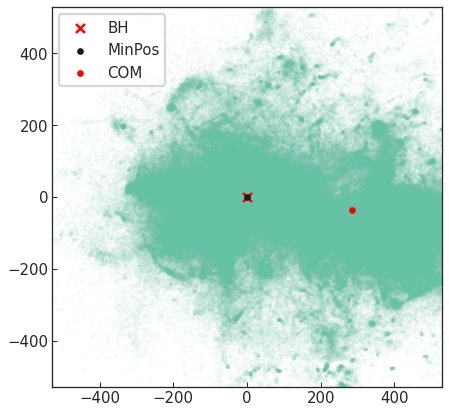

[285.29688  -36.195312  84.234375] [-0.03125    -0.03710938 -0.015625  ]


In [88]:
gidx = 8
tarid = 258459903385

ichunk = group_chunk_dir(gidx)
chunkdir = glob.glob(subroot + "/chunk%d.*"%ichunk)[0]
print(chunkdir)


tab = h5py.File(chunkdir + '/output/' + tabfile,'r')
snap = h5py.File(chunkdir + '/output/' + grpfile,'r')


mass5 = snap['PartType5/BH_Mass'][:]
id5 = snap['PartType5/ParticleIDs'][:]
pos5 = snap['PartType5/Coordinates'][:]
pos4  = snap['PartType4/Coordinates'][:]


sLen = tab['Subhalo']['SubhaloLenType'][:]
sOff = tab['Subhalo']['SubhaloOffsetType'][:]

sCenter = tab['Subhalo']['SubhaloPos'][:]
com = tab['Subhalo']['SubhaloCM'][:]

bidx = (id5 == tarid).nonzero()[0][0]
print(bidx)

sidx_tar = place(bidx,sOff[:,5])
print(sidx_tar)




pp = pos5[bidx]
centers = sCenter - pp
pos4 = pos4 - pp
com = com - pp


sidx = 0
start, end = sOff[sidx], sOff[sidx] + sLen[sidx]
ppos = pos4[start[4] : end[4]] 



box = 530
fig, ax = plt.subplots(1,1,figsize=(7,7))


ax.scatter(ppos[:,0], ppos[:,1], s=0.001)
ax.scatter(0, 0, s=80, color='red', marker='x', label='BH')
ax.scatter(centers[0, 0], centers[0,1], s=20, marker="o", color='k', label='MinPos')
ax.scatter(com[0, 0], com[0,1], s=20, marker="o", color='red', label='COM')
# ax.scatter(centers[220, 0], centers[220,1], s=50, color='blue', marker='o')
ax.legend()
ax.set(xlim=[-box,box], ylim=[-box,box])
plt.show()

print(com[0], centers[0])




## misc tests for bigfile subfind cat

### this is for the missing chunk problem (already fixed)

In [16]:
import glob
subroot = "/home1/08942/nianyic/scratch3/Astrid/subfind/subfind-483"

def get_subfind_chunk(subroot):
    subdir = subroot + '/chunk*'
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    
    return chunk_list, maxgroup_list 


chunk_list, maxgroup_list = get_subfind_chunk(subroot)

In [25]:
aa = np.searchsorted(off[:,0], 6964853995)

In [26]:
bb = np.searchsorted(off[:,0], 6974853995)

In [27]:
print(aa, bb)

4635 4650


In [9]:
def get_subfind_chunk(subroot):
    subdir = subroot + '/chunk*'
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    
    return chunk_list, maxgroup_list 


In [11]:
import glob
subroot = "/home1/08942/nianyic/scratch3/Astrid/subfind/subfind-483"
chunk_list, maxgroup_list = get_subfind_chunk(subroot)

In [15]:
maxgroup_list[200:220]

array([212, 223, 233, 244, 255, 267, 278, 290, 302, 314, 327, 340, 353,
       366, 380, 393, 407, 421, 436, 451])

In [30]:
aa = np.array([20,19,10,8])
np.searchsorted(aa, 5)

0

In [33]:
aa = np.array([20,19,10,8,4,1])
np.searchsorted(-aa, -5)

4

#### sanity check for subhalo properties

In [103]:
sfile = "/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind"
pig2 = BigFile(sfile)

firstsub = pig2['FOFGroups/GroupFirstSub'][-100:]
nsub = pig2['FOFGroups/GroupNsubs'][-100:]

In [104]:
firstsub[1:]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int32)

In [105]:
np.cumsum(nsub)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### group reorder debug

In [7]:
(10*16 + 3)*404123608/4

16468037026.0

In [4]:
hh = 0.6774
pig = BigFile("/home1/08942/nianyic/ASTRID2_PIG/PIG_483/")
Length = pig['FOFGroups/LengthByType']
Offset = pig['FOFGroups/OffsetByType'][:30000000]

In [8]:
np.searchsorted(Offset[:,4], 16468037026)

60156

## reassignment test

## other consistency test

In [3]:
outdir = '/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind'
pig2 = BigFile(outdir)

In [4]:
gLength = pig2['FOFGroups/LengthByType']
gOffset = pig2['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

### random selectino

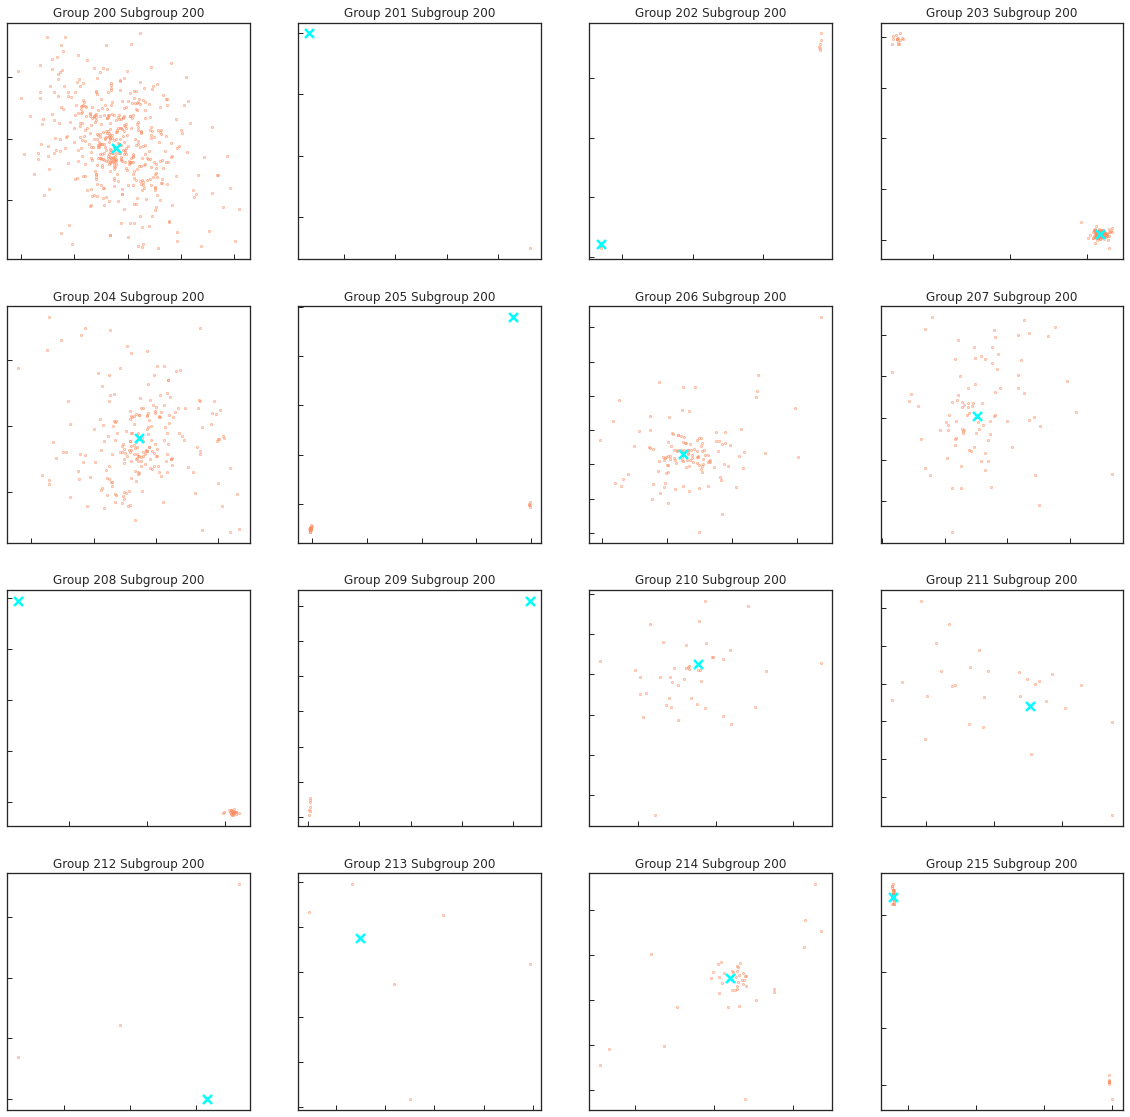

In [8]:
p = 4
gidx = 200
isub = 200

fig,ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

test_groups = np.arange(gidx,gidx+16)

for i,gidx in enumerate(test_groups):
    firstsub = FirstSub[gidx]
    gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]

    sidx = firstsub + isub
    
    sstart = (gstart + np.sum(sLength[firstsub:firstsub+isub],axis=0)).astype(int)
    send = (sstart + sLength[sidx]).astype(int)
    

    sstart = sOffset[sidx]
    send   = sOffset[sidx] + sLength[sidx]

    m1 = sMass[sidx][4]
    m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)

    pos = pig2['%d/Position'%p][gstart[p]:gend[p]]
    spos = pig2['%d/Position'%p][sstart[p]:send[p]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 


    
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax[i].scatter(spos[:,0],spos[:,1],s=0.3,color=cmap(1))
    ax[i].scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax[i].set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax[i].set(xticklabels=[],yticklabels=[])
# plt.savefig('test_sub0.png',bbox_inches='tight')
plt.show()

Error: b"Failed to open physical file `/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind/1/Mass/header' with mode `r' (No such file or directory) @(src/bigfile.c:1935) @(src/bigfile.c:337)"

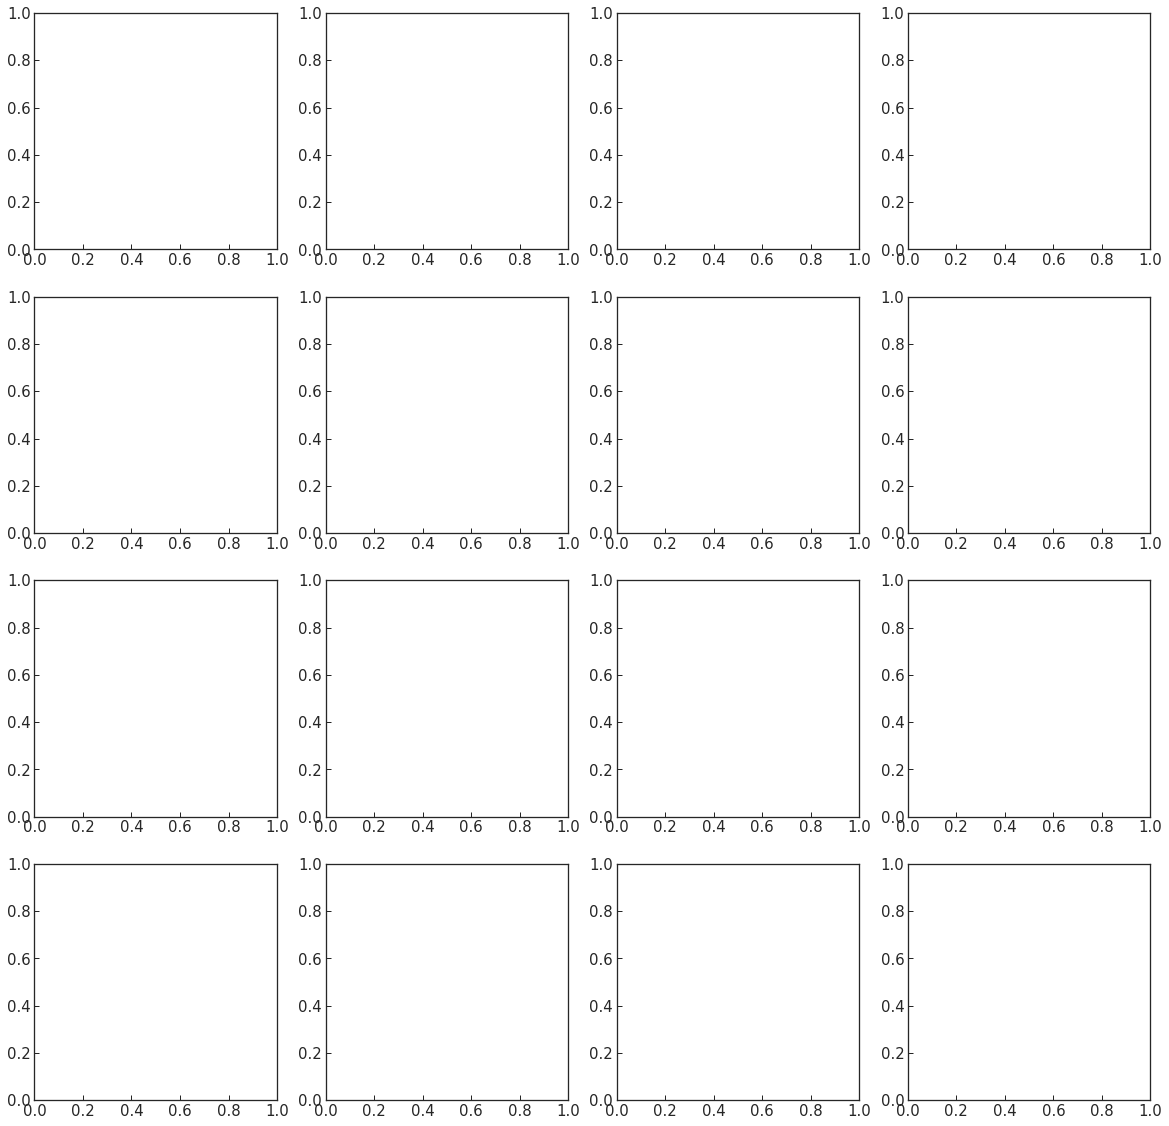

In [12]:
p = 1
gidx = 200
isub = 200

fig,ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

test_groups = np.arange(gidx,gidx+16)

for i,gidx in enumerate(test_groups):
    firstsub = FirstSub[gidx]
    gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]

    sidx = firstsub + isub
    
    sstart = (gstart + np.sum(sLength[firstsub:firstsub+isub],axis=0)).astype(int)
    send = (sstart + sLength[sidx]).astype(int)
    

    # sstart = sOffset[sidx]
    # send   = sOffset[sidx] + sLength[sidx]

    m1 = sMass[sidx][4]
    m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)

    pos = pig2['%d/Position'%p][gstart[p]:gend[p]]
    spos = pig2['%d/Position'%p][sstart[p]:send[p]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 


    
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax[i].scatter(spos[:,0],spos[:,1],s=0.3,color=cmap(1))
    ax[i].scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax[i].set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax[i].set(xticklabels=[],yticklabels=[])
# plt.savefig('test_sub0.png',bbox_inches='tight')
plt.show()